In [1]:
import numpy as np
from sklearn.decomposition import PCA
import h5py
import pickle
import matplotlib.pyplot as plt
import GPy

In [2]:
def gp_predict(model, params):
    """
    Predicts the weights matrix to feed inverse PCA from physical parameters.

    Input :
    - model : GP model
    - params : physical parameters (flux, radius, shear profile, psf fwhm)

    Output :
    - predic[0] : predicted weights
    """
    predict = model.predict(params)
    return predict[0]


def emulator(pca_model, gp_model, params):
    """
    Emulates new images from physical parameters.

    Input :
    - pca : PCA model
    - gp_model : GP model
    - params : physical parameters (flux, radius, shear profile, psf fwhm)

    Output :
    - reconstructed : Emulated image
    """
    # Weights prediction
    params = np.expand_dims(params, axis = 0)
    pred_weights = gp_predict(gp_model, params)

    # Inverse PCA (pred_weights * basis + mean)
    reconstructed = pca_model.inverse_transform(pred_weights)
    return reconstructed[0]


In [3]:
save_loc = "/Users/nramachandra/Desktop/Projects/AGNfinder/FSPS/"

with h5py.File(save_loc + 'fsps_cache.hdf5', 'r') as f:
   X_loaded = f['fsps_cache']['X'][...]
   Y_loaded = f['fsps_cache']['Y'][...] 


We are only emulating y-values over 10^-23 ish 

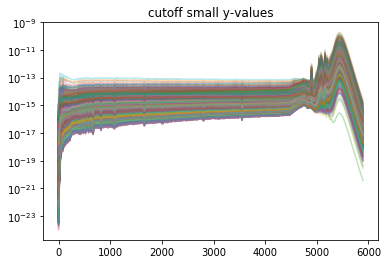

In [10]:
plt.plot(Y_loaded.T[100:,:], alpha = 0.3)
plt.yscale('log')
plt.title('cutoff small y-values')
plt.show()

In [35]:
## logging and clipping
# X_loaded = np.log10(X_loaded)
Y_log = np.log10(Y_loaded[:, 100:])

# ### rescaling 
y_mean = np.mean(Y_log, axis=0)
y_mult = np.max(Y_log - y_mean, axis=0)

y_train = (Y_log - y_mean)/y_mult

# ### rescaling 
x_mean = np.mean(X_loaded, axis=0)
x_mult = np.max(X_loaded - x_mean, axis=0)

x_train = (X_loaded - x_mean)/x_mult

In [44]:
(y_train * y_mult) + y_mean

array([[-19.80387467, -19.65389833, -19.27708761, ..., -16.45932962,
        -16.47098387, -16.48238313],
       [-20.91042541, -20.73808564, -20.33861979, ..., -16.96454943,
        -16.97620365, -16.98760288],
       [-17.12693713, -17.11773563, -16.88484856, ..., -17.4250831 ,
        -17.43673722, -17.44813635],
       ...,
       [-18.08373113, -18.03817224, -17.76821478, ..., -17.34504691,
        -17.35670107, -17.36810024],
       [-17.68258799, -17.6432174 , -17.37949861, ..., -17.1280704 ,
        -17.13972458, -17.15112378],
       [-17.24694068, -17.23246618, -16.99419104, ..., -17.38775209,
        -17.39940622, -17.41080537]])

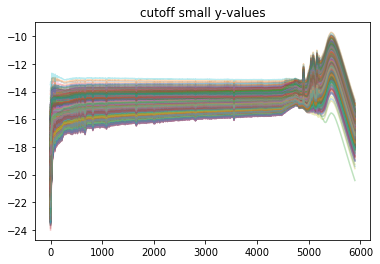

In [45]:
plt.plot( ((y_train*y_mult)+y_mean).T, alpha = 0.3)
# plt.plot(Y_log.T, alpha = 0.3)
# plt.plot(y_train.T, alpha = 0.3)
# plt.yscale('log')
plt.title('cutoff small y-values')
plt.show()

## loading trained GP and PCA models

In [47]:
num_params = 3
num_bases = 10

with open('pcaModel.pickle', 'rb') as handle:
    pca_model = pickle.load(handle)

gp_model = GPy.models.GPRegression.load_model('gpfit_'+str(num_bases)+'_'+str(num_params) + '.zip')

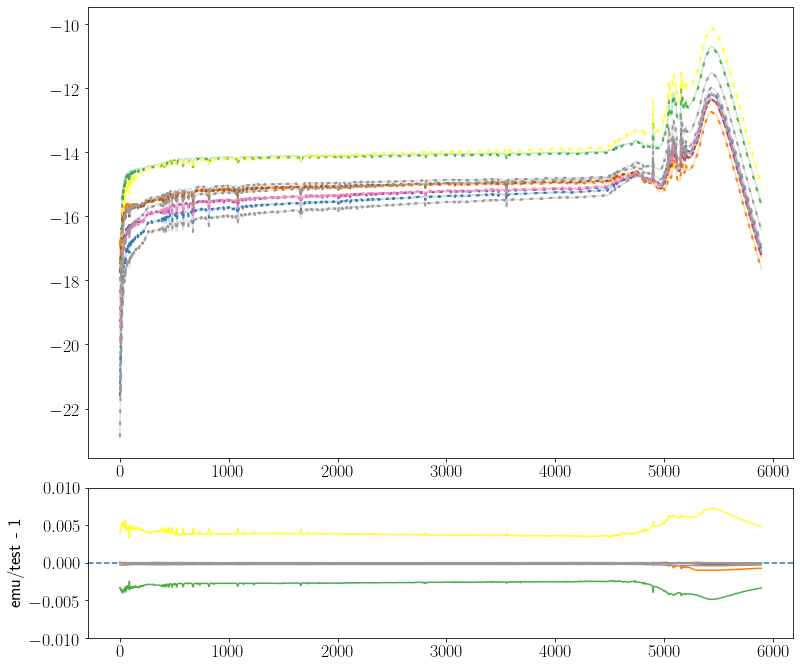

In [51]:
np.random.seed(12)

from matplotlib import gridspec
from itertools import cycle
import matplotlib.ticker as ticker

plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=18)  # 18 usually

plt.figure(999, figsize=(14, 12))


gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.1, left=0.2, bottom=0.15, wspace=0.25)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# ax0.set_ylabel(r'$P(k)$',  fontsize = 18)

# ax1.set_xlabel(r'$k$',  fontsize = 18)
ax1.axhline(y=0, ls='dashed')


# ax0.set_yscale('log', basey=10)
# ax0.set_xscale('log', basex=10)
# ax1.set_xscale('log', basex=10)

ax1.set_ylim(-0.01, 0.01)

# ax0.plot(y_train.T*y_mult + y_mean , 'k-', alpha = 0.01)
# ax0.plot(10**y_train.T, 'k-', alpha = 0.01)

ax1.set_ylabel(r'emu/test - 1',  fontsize = 18)


start, end = ax0.get_ylim()
# ax0.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1e1'))

color_id = 0
for i in range(10):
    color_id += 1
    rand_idx = (np.random.randint(100, 2000))
    rand_params = x_train[rand_idx]
    y_emu = emulator(pca_model, gp_model, rand_params)
    y_true = y_train[rand_idx]
    ax0.plot( ((y_emu*y_mult) + y_mean).T, color=plt.cm.Set1(color_id), alpha = 0.3)
    ax0.plot( ((y_true*y_mult) + y_mean).T, '--', color=plt.cm.Set1(color_id), lw = 2, dashes=(2, 4))

    ax1.plot( (( (y_emu*y_mult) + y_mean) ).T/(( (y_true*y_mult) + y_mean) ).T - 1, color=plt.cm.Set1(color_id))

    
plt.show()

In [36]:
%%timeit

emulator(pca_model, gp_model, rand_params)

5.68 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [81]:
Y_loaded[20][100:]

array([1.30119626e-21, 2.00969377e-21, 5.24212363e-21, ...,
       2.69949273e-17, 2.62801547e-17, 2.55993336e-17])

In [80]:
10**(y_train[20]*y_mult + y_mean)

array([1.30119626e-21, 2.00969377e-21, 5.24212363e-21, ...,
       2.69949273e-17, 2.62801547e-17, 2.55993336e-17])

In [89]:
y_train[20]

array([-0.24114212, -0.23529265, -0.22862128, ...,  0.15895811,
        0.15895807,  0.15895803])

In [96]:
%%timeit

y_emu = emulator(pca_model, gp_model, x_train[20])

5.02 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [97]:
y_emu

array([-0.12854466, -0.12365808, -0.11817861, ...,  0.20276326,
        0.2027632 ,  0.20276315])

In [98]:
10**(y_emu*y_mult + y_mean)

array([6.07543059e-21, 8.90823159e-21, 2.20419897e-20, ...,
       3.42322385e-17, 3.33258327e-17, 3.24624814e-17])